In [4]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score,
                           recall_score, f1_score,
                           confusion_matrix, classification_report)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import plot_tree
import nltk
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, LSTM,
                                   Embedding, Bidirectional)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
# 1. Data Loading and Preprocessing
with open('/content/dataset.json', 'r') as file:
    intents = json.load(file)

words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']

for intent in intents['intents']:
    for pattern in intent['patterns']:
        word_list = nltk.word_tokenize(pattern)
        words.extend(word_list)
        documents.append((pattern, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))


In [6]:
# 2. Feature Engineering
vectorizer = TfidfVectorizer(
    max_features=2000,
    stop_words='english',
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.85
)

X = vectorizer.fit_transform([doc[0] for doc in documents]).toarray()
y = np.array([classes.index(doc[1]) for doc in documents])

# Handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
y_onehot = tf.keras.utils.to_categorical(y_resampled, num_classes=len(classes))

# Train-test split
trainX, testX, trainY, testY = train_test_split(
    X_resampled, y_onehot, test_size=0.2, random_state=42)

# Sequence data for LSTM
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts([doc[0] for doc in documents])
vocab_size = len(tokenizer.word_index) + 1

X_texts = [doc[0] for doc in documents]
X_seq = tokenizer.texts_to_sequences(X_texts)
max_len = max([len(x) for x in X_seq])
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

# Apply SMOTE to LSTM data
X_resampled_lstm, y_resampled_lstm = smote.fit_resample(X_pad, y)
y_onehot_lstm = tf.keras.utils.to_categorical(y_resampled_lstm, num_classes=len(classes))

# Train-test split for LSTM
trainX_lstm, testX_lstm, trainY_lstm, testY_lstm = train_test_split(
    X_resampled_lstm, y_onehot_lstm, test_size=0.2, random_state=42)


In [7]:
# 3. Visualization Functions
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, feature_names, model_name):
    importances = model.feature_importances_
    filtered_features = [
        (feature, importance)
        for feature, importance in zip(feature_names, importances)
        if len(feature) > 2 and not any(char.isdigit() for char in feature)
    ]
    top_features = sorted(filtered_features, key=lambda x: x[1], reverse=True)[:15]

    plt.figure(figsize=(10, 6))
    plt.barh(
        [feature for feature, _ in top_features],
        [importance for _, importance in top_features],
        color='dodgerblue'
    )
    plt.title(f'Top 15 {model_name} Features')
    plt.xlabel('Importance Score')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def plot_model_metrics(y_true, y_pred, model_name):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1': f1_score(y_true, y_pred, average='weighted')
    }

    plt.figure(figsize=(8, 4))
    plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'orange', 'red'])
    plt.title(f'{model_name} Performance Metrics')
    plt.ylim(0, 1.1)
    plt.ylabel('Score')
    for i, v in enumerate(metrics.values()):
        plt.text(i, v + 0.05, f"{v:.2f}", ha='center')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_learning_curve_xgb(model):
    results = model.evals_result()
    epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)

    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, results['validation_0']['merror'], label='Train')
    plt.plot(x_axis, results['validation_1']['merror'], label='Test')
    plt.title('XGBoost Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.show()

def plot_sample_decision_tree(model, feature_names, class_names):
    plt.figure(figsize=(20, 10))
    plot_tree(
        model.estimators_[0],
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        max_depth=3
    )
    plt.title("Sample Decision Tree from Random Forest")
    plt.show()

In [8]:
# 4. Model Definitions
def create_nn_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,), kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(len(classes), activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'])
    return model

def create_lstm_model(vocab_size, max_len):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=max_len, mask_zero=True),
        Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))),
        Dropout(0.3),
        Bidirectional(LSTM(32, kernel_regularizer=l2(0.001))),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(len(classes), activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.0005),
                metrics=['accuracy'])
    return model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training Neural Network...
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.0798 - loss: 3.6993 - val_accuracy: 0.1591 - val_loss: 3.6459
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2417 - loss: 3.5998 - val_accuracy: 0.2500 - val_loss: 3.5684
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3996 - loss: 3.4960 - val_accuracy: 0.2841 - val_loss: 3.4799
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4983 - loss: 3.3631 - val_accuracy: 0.3182 - val_loss: 3.3747
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4923 - loss: 3.2059 - val_accuracy: 0.4205 - val_loss: 3.2500
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5318 - loss: 3.0219 - val_accuracy: 0.4659 - val_loss: 3.0912
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6289 - loss: 2.7456 - val_accuracy: 0.4886 - val_loss: 2.8957
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6521 - loss: 2.4334 - 

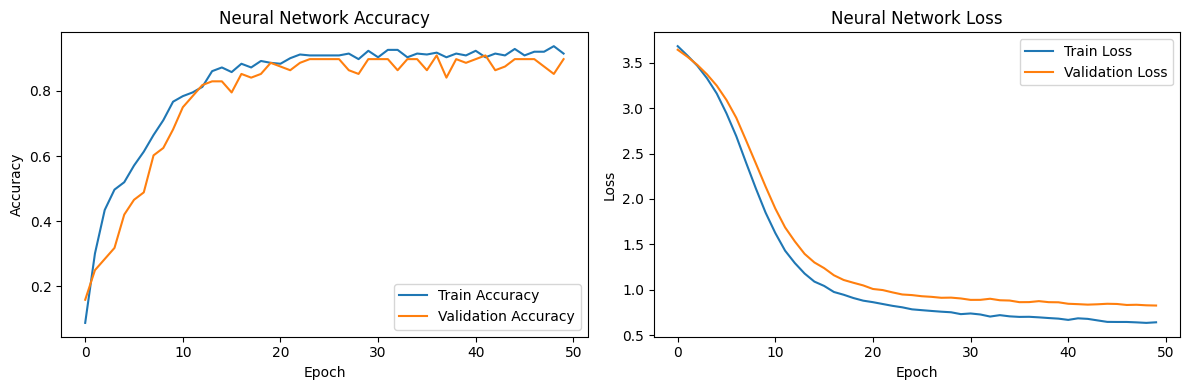

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


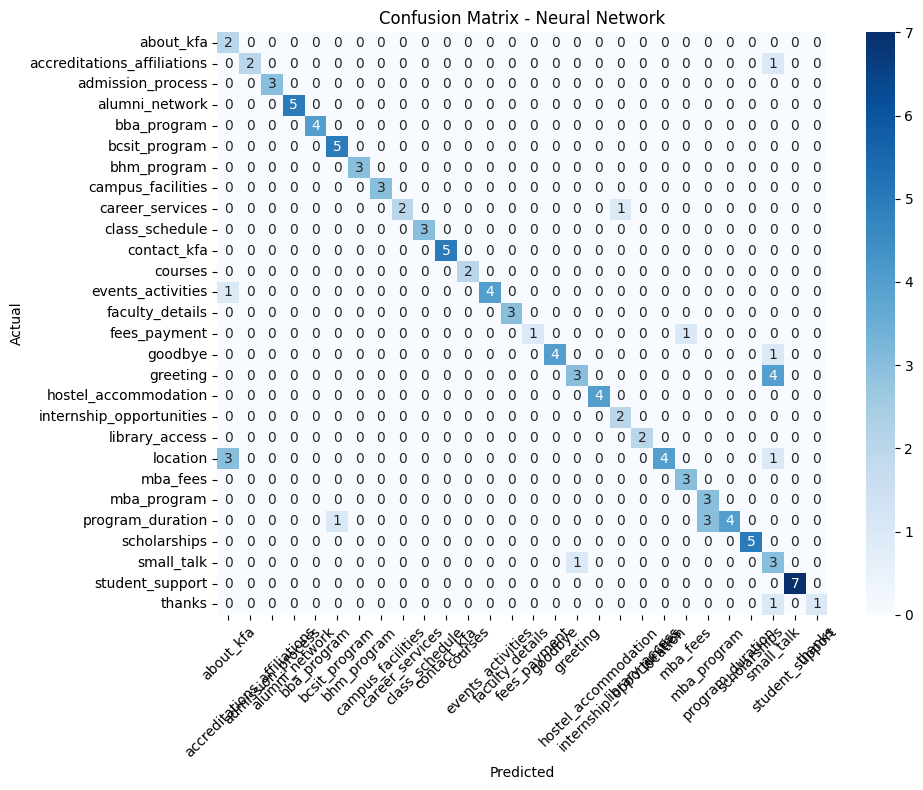

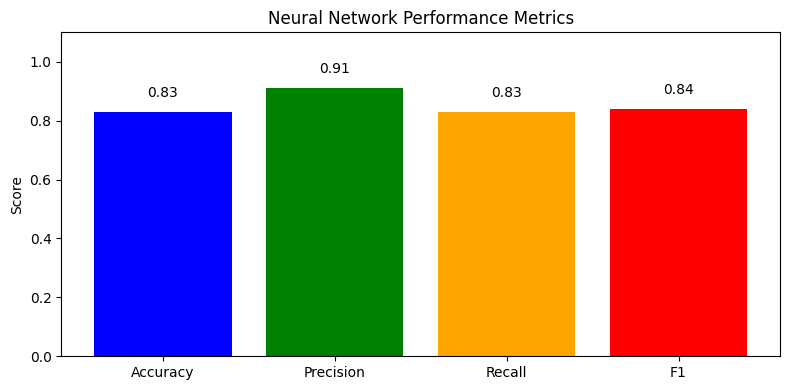


Classification Report for Neural Network:
                             precision    recall  f1-score   support

                  about_kfa       0.33      1.00      0.50         2
accreditations_affiliations       1.00      0.67      0.80         3
          admission_process       1.00      1.00      1.00         3
             alumni_network       1.00      1.00      1.00         5
                bba_program       1.00      1.00      1.00         4
              bcsit_program       0.83      1.00      0.91         5
                bhm_program       1.00      1.00      1.00         3
          campus_facilities       1.00      1.00      1.00         3
            career_services       1.00      0.67      0.80         3
             class_schedule       1.00      1.00      1.00         3
                contact_kfa       1.00      1.00      1.00         5
                    courses       1.00      1.00      1.00         2
          events_activities       1.00      0.80      0.89 

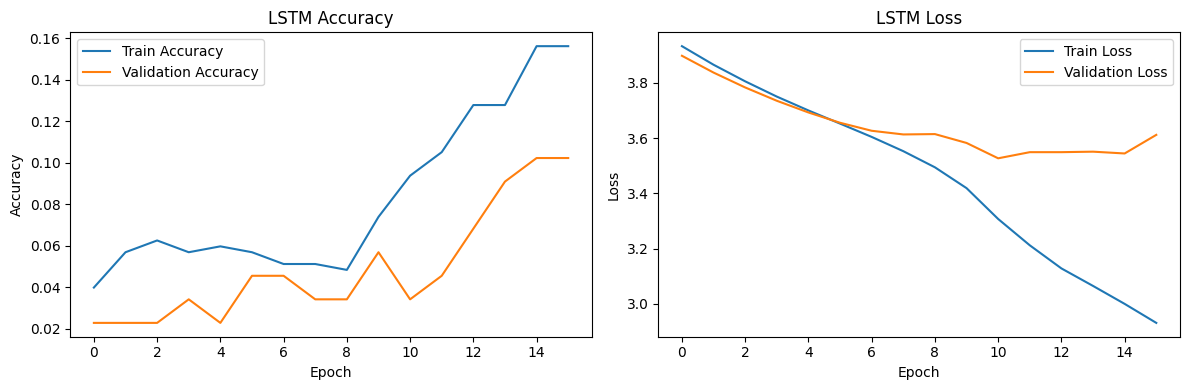

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step


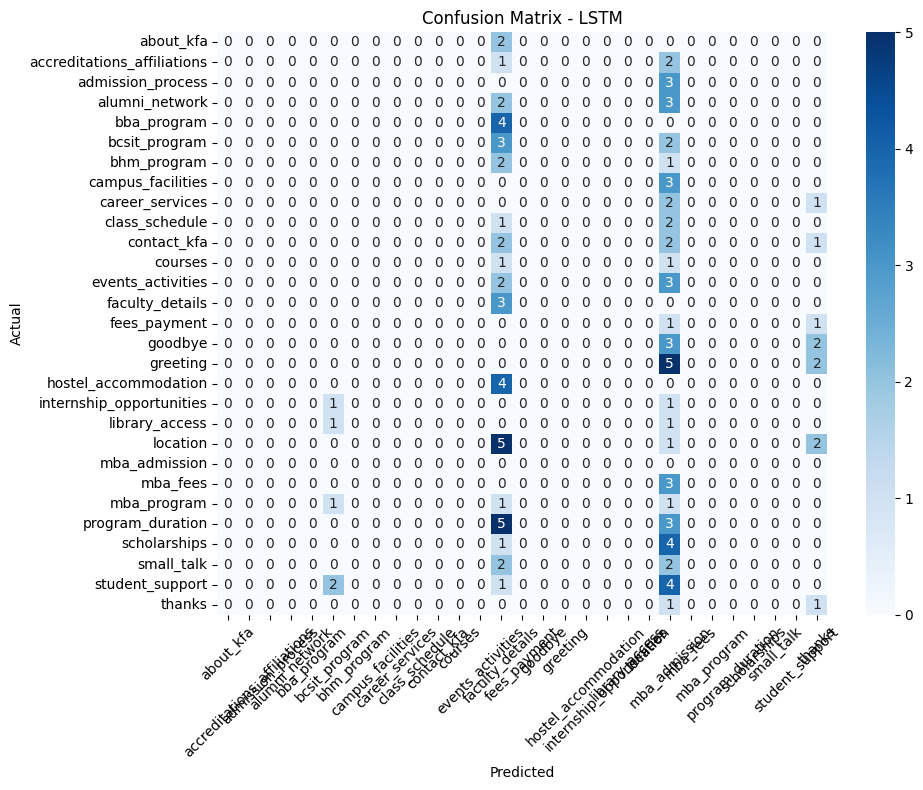

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


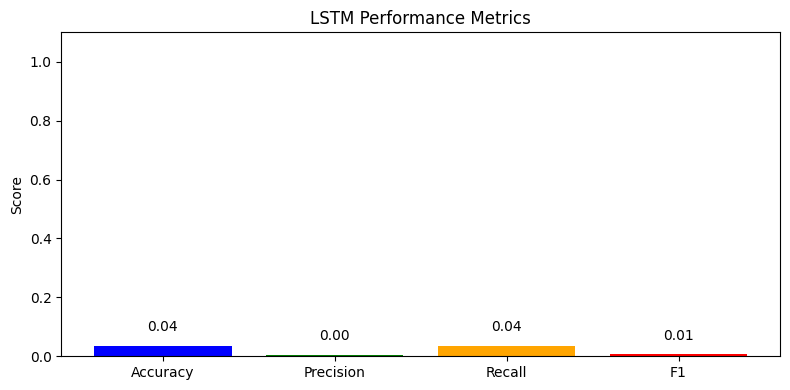

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for LSTM:
                             precision    recall  f1-score   support

                  about_kfa       0.00      0.00      0.00         2
accreditations_affiliations       0.00      0.00      0.00         3
          admission_process       0.00      0.00      0.00         3
             alumni_network       0.00      0.00      0.00         5
                bba_program       0.00      0.00      0.00         4
              bcsit_program       0.00      0.00      0.00         5
                bhm_program       0.00      0.00      0.00         3
          campus_facilities       0.00      0.00      0.00         3
            career_services       0.00      0.00      0.00         3
             class_schedule       0.00      0.00      0.00         3
                contact_kfa       0.00      0.00      0.00         5
                    courses       0.00      0.00      0.00         2
          events_activities       0.00      0.00      0.00         5


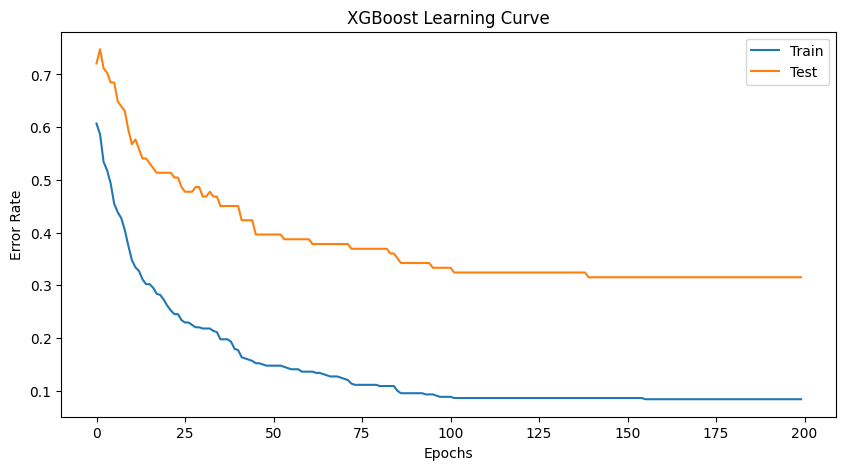

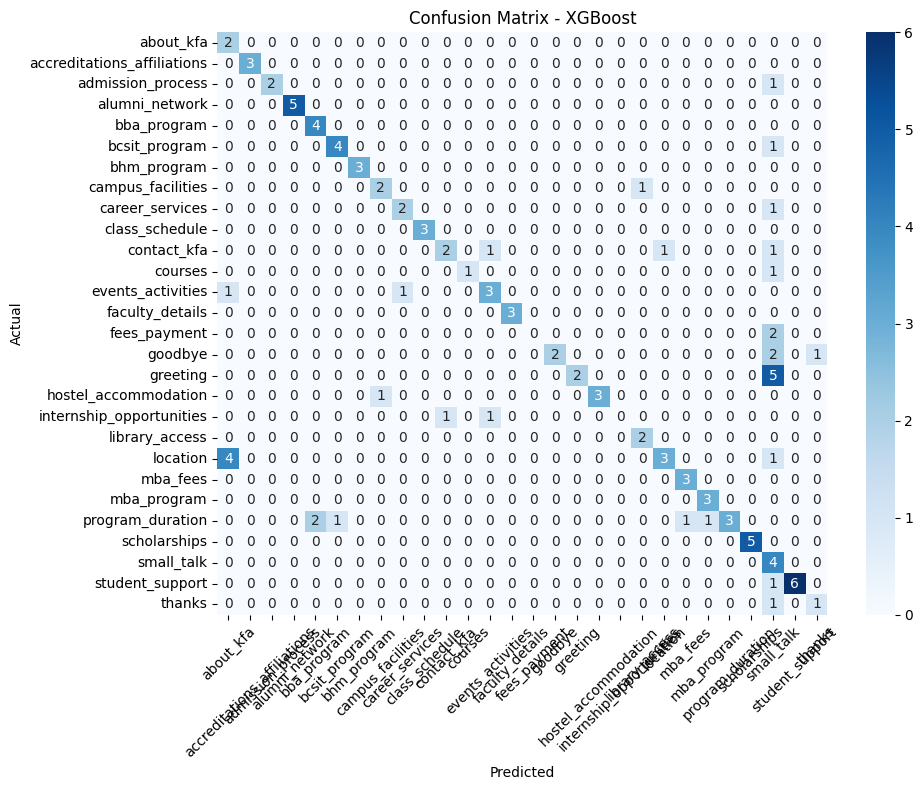

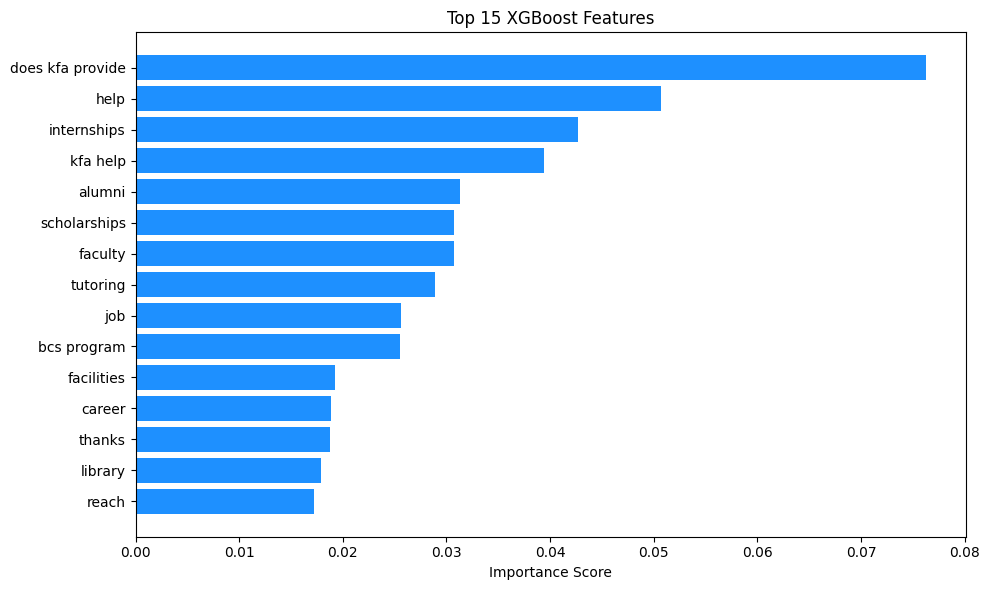

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


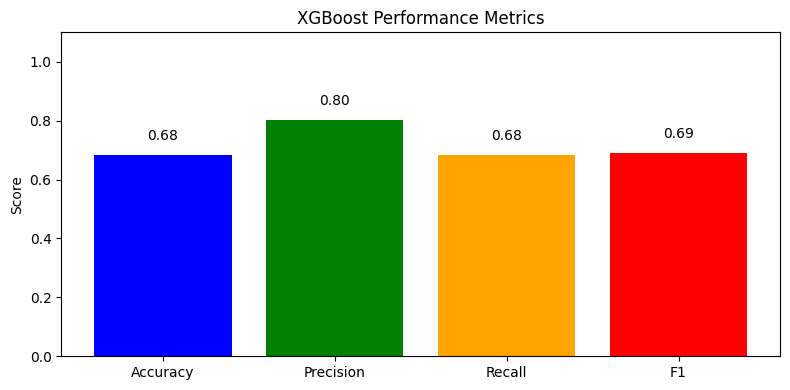


Classification Report for XGBoost:
                             precision    recall  f1-score   support

                  about_kfa       0.29      1.00      0.44         2
accreditations_affiliations       1.00      1.00      1.00         3
          admission_process       1.00      0.67      0.80         3
             alumni_network       1.00      1.00      1.00         5
                bba_program       0.67      1.00      0.80         4
              bcsit_program       0.80      0.80      0.80         5
                bhm_program       1.00      1.00      1.00         3
          campus_facilities       0.67      0.67      0.67         3
            career_services       0.67      0.67      0.67         3
             class_schedule       1.00      1.00      1.00         3
                contact_kfa       0.67      0.40      0.50         5
                    courses       1.00      0.50      0.67         2
          events_activities       0.60      0.60      0.60        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


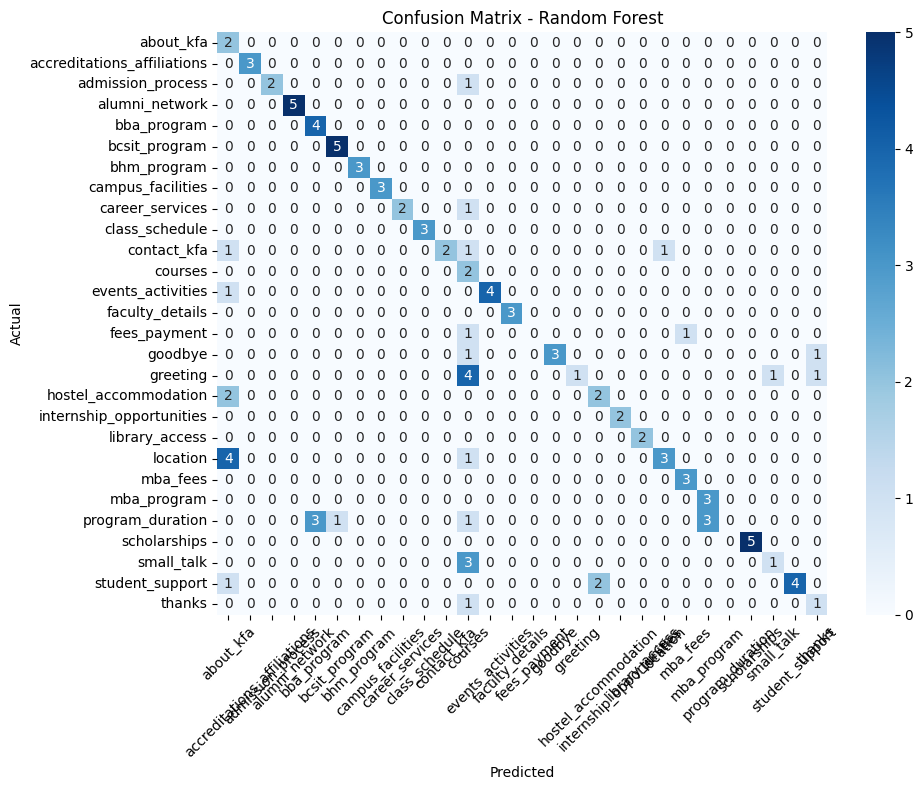

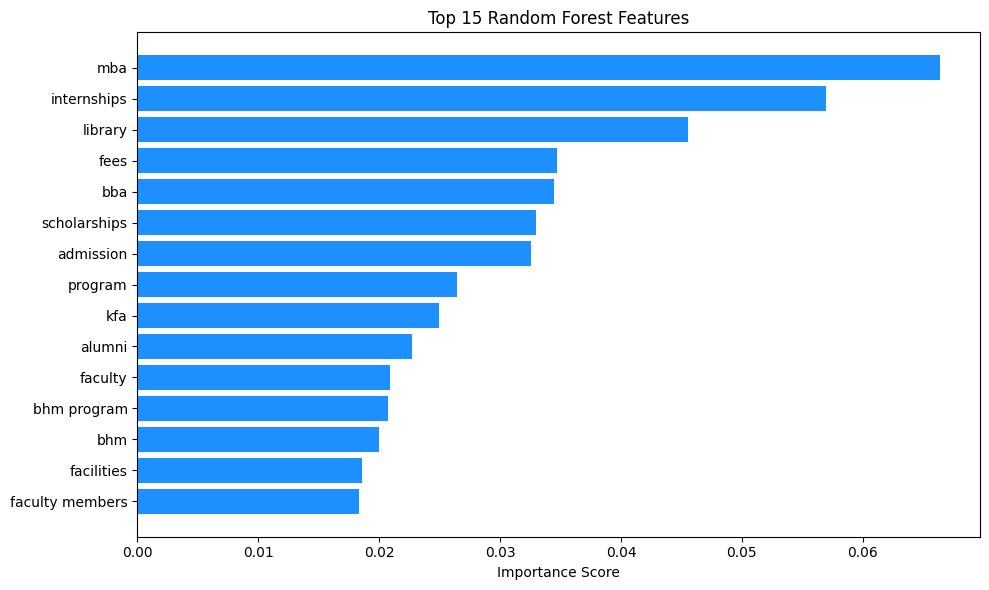

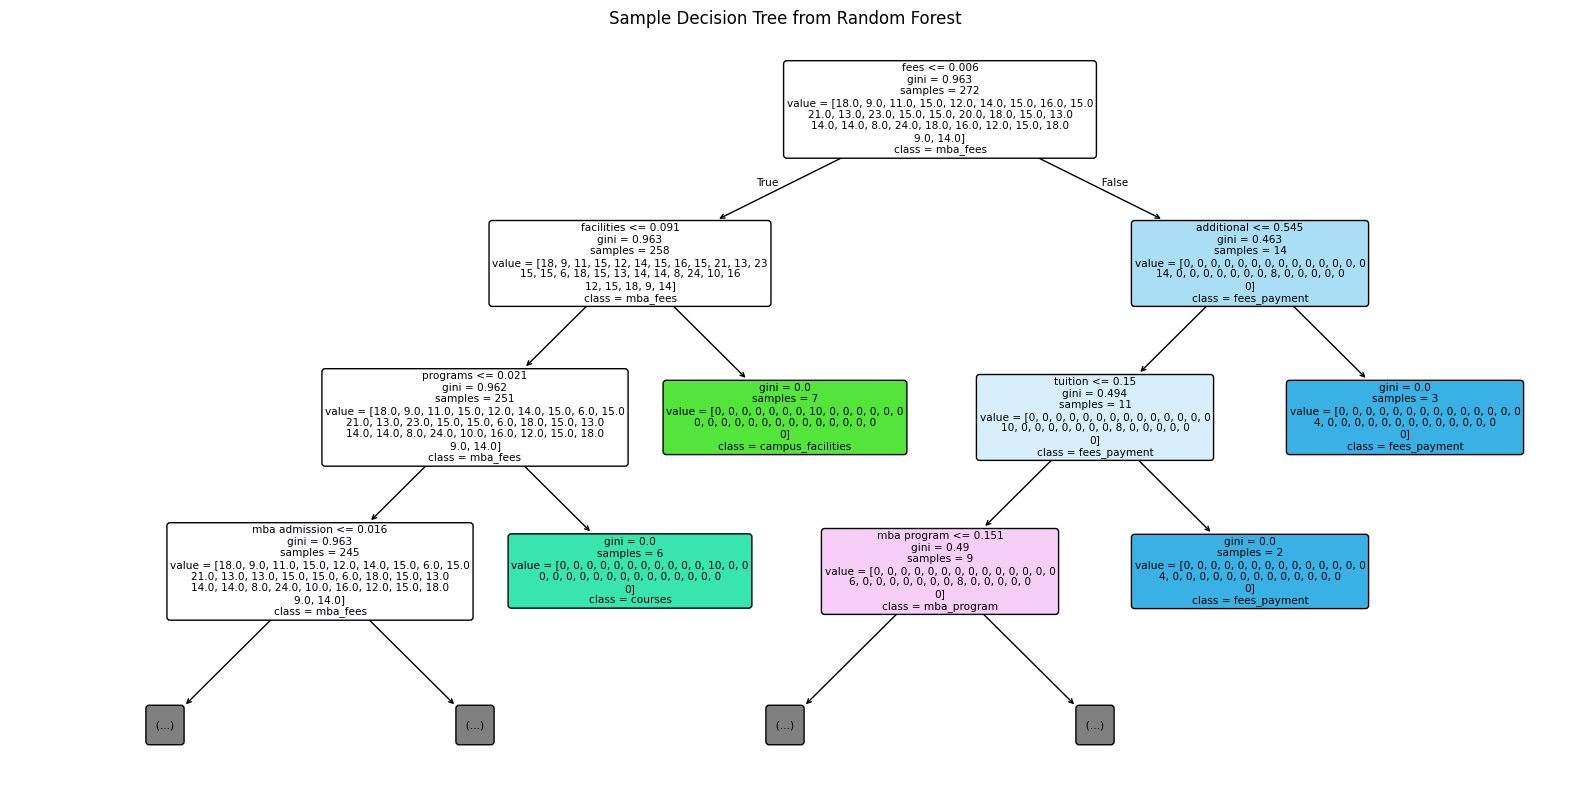

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


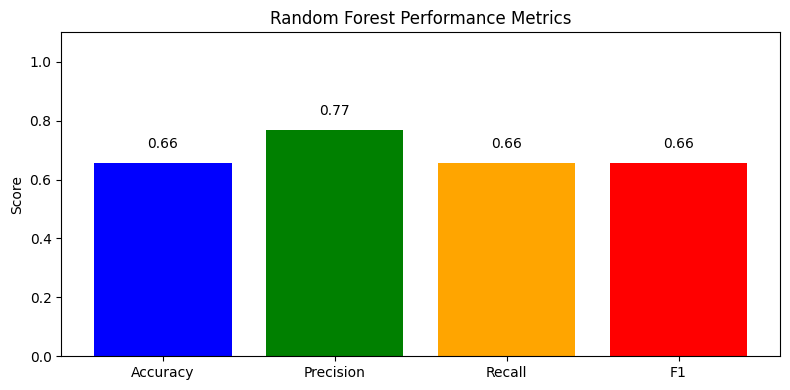


Classification Report for Random Forest:
                             precision    recall  f1-score   support

                  about_kfa       0.18      1.00      0.31         2
accreditations_affiliations       1.00      1.00      1.00         3
          admission_process       1.00      0.67      0.80         3
             alumni_network       1.00      1.00      1.00         5
                bba_program       0.57      1.00      0.73         4
              bcsit_program       0.83      1.00      0.91         5
                bhm_program       1.00      1.00      1.00         3
          campus_facilities       1.00      1.00      1.00         3
            career_services       1.00      0.67      0.80         3
             class_schedule       1.00      1.00      1.00         3
                contact_kfa       1.00      0.40      0.57         5
                    courses       0.12      1.00      0.21         2
          events_activities       1.00      0.80      0.89  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
# 5. Model Training and Evaluation
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test,
                           is_nn=False, model_name="", epochs=50, batch_size=32):
    if is_nn:
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                          validation_split=0.2, verbose=1, callbacks=[early_stopping])
        plot_training_history(history, model_name)
    else:
        if model_name == "XGBoost":
            # Initialize XGBoost with correct parameters
            model = XGBClassifier(
                n_estimators=200,
                learning_rate=0.05,
                random_state=42,
                eval_metric='merror'
            )
            eval_set = [(X_train, np.argmax(y_train, axis=1)), (X_test, np.argmax(y_test, axis=1))]
            model.fit(
                X_train,
                np.argmax(y_train, axis=1),
                eval_set=eval_set,
                verbose=False
            )
            plot_learning_curve_xgb(model)
        else:
            model.fit(X_train, np.argmax(y_train, axis=1))

    y_pred = model.predict(X_test)
    if is_nn:
        y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    present_classes = np.unique(np.concatenate([y_true, y_pred]))
    present_class_names = [classes[i] for i in present_classes]

    plot_confusion_matrix(y_true, y_pred, present_class_names, model_name)
    if not is_nn:
        feature_names = vectorizer.get_feature_names_out()
        plot_feature_importance(model, feature_names, model_name)
        if model_name == "Random Forest":
            plot_sample_decision_tree(model, feature_names, present_class_names)
    plot_model_metrics(y_true, y_pred, model_name)

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred,
                              labels=present_classes,
                              target_names=present_class_names,
                              zero_division=0))

    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1': f1_score(y_true, y_pred, average='weighted')
    }

# Initialize models
models = {
    'Neural Network': create_nn_model(trainX.shape[1]),
    'LSTM': create_lstm_model(vocab_size, max_len),
    'XGBoost': XGBClassifier(n_estimators=200, learning_rate=0.05, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
}

# Train and evaluate all models
results = {}
for name, model in models.items():
    print(f"\n{'='*50}\nTraining {name}...\n{'='*50}")
    if name in ['Neural Network', 'LSTM']:
        results[name] = train_and_evaluate_model(
            model,
            trainX if name == 'Neural Network' else trainX_lstm,
            trainY if name == 'Neural Network' else trainY_lstm,
            testX if name == 'Neural Network' else testX_lstm,
            testY if name == 'Neural Network' else testY_lstm,
            is_nn=True,
            model_name=name,
            epochs=100 if name == 'LSTM' else 50
        )
    else:
        results[name] = train_and_evaluate_model(
            model,
            trainX,
            trainY,
            testX,
            testY,
            model_name=name
        )



Model Performance Comparison:
                Accuracy  Precision    Recall        F1
Neural Network  0.828829   0.912230  0.828829  0.839255
XGBoost         0.684685   0.803303  0.684685  0.689794
Random Forest   0.657658   0.769982  0.657658  0.656651
LSTM            0.036036   0.003732  0.036036  0.006607


<Figure size 1000x600 with 0 Axes>

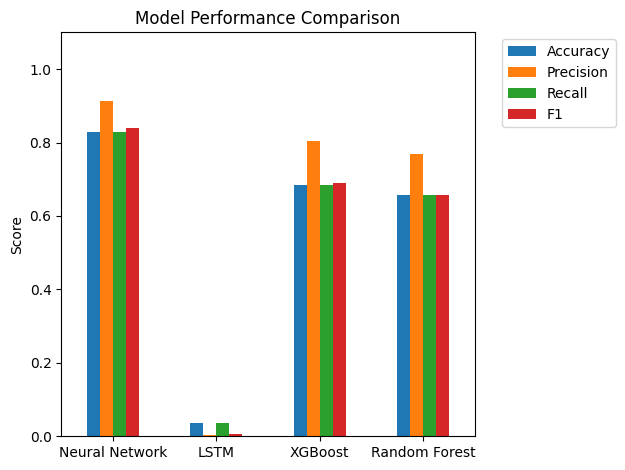

In [10]:
# 6. Results Comparison
results_df = pd.DataFrame.from_dict(results, orient='index')
print("\nModel Performance Comparison:")
print(results_df.sort_values('Accuracy', ascending=False))

plt.figure(figsize=(10, 6))
results_df.plot(kind='bar', rot=0)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [11]:
# 7. Save Best Model as "kfabot"
best_model_name = results_df['Accuracy'].idxmax()
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")

if best_model_name in ['Neural Network', 'LSTM']:
    best_model.save('kfabot.keras')
    print("Saved Keras model as 'kfabot.keras'")
else:
    pickle.dump(best_model, open('kfabot.pkl', 'wb'))
    print("Saved model as 'kfabot.pkl'")

# Save vectorizer and tokenizer
pickle.dump(vectorizer, open('tfidf_vectorizer.pkl', 'wb'))
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))
print("Saved vectorizer and tokenizer.")


Best Model: Neural Network
Saved Keras model as 'kfabot.keras'
Saved vectorizer and tokenizer.


In [12]:
# Load all chatbot resources
from tensorflow.keras.models import load_model

def load_chatbot():
    print("Loading chatbot resources...")

    # Load intents and training data
    intents = json.load(open('/content/dataset.json'))
    words = pickle.load(open('words.pkl', 'rb'))
    classes = pickle.load(open('classes.pkl', 'rb'))
    vectorizer = pickle.load(open('tfidf_vectorizer.pkl', 'rb'))

    # Try to load the best model (Keras or sklearn)
    try:
        model = load_model('kfabot.keras')
        model_type = 'keras'
    except:
        model = pickle.load(open('kfabot.pkl', 'rb'))
        model_type = 'sklearn'

    print("Chatbot ready!")
    return intents, words, classes, model, model_type, vectorizer


In [13]:
# Process user input
def process_input(sentence):
    # Tokenize and lemmatize
    sentence_words = nltk.word_tokenize(sentence)
    return [lemmatizer.lemmatize(word.lower()) for word in sentence_words]

# Predict the intent
def predict_intent(sentence, model, model_type, classes, vectorizer):
    # Process and vectorize input
    sentence_processed = " ".join(process_input(sentence))
    features = vectorizer.transform([sentence_processed]).toarray()[0]

    # Get prediction based on model type
    if model_type == 'keras':
        predictions = model.predict(np.array([features]))[0]
    else:
        predictions = model.predict_proba([features])[0]

    # Filter predictions with confidence threshold
    results = []
    for i, prob in enumerate(predictions):
        if prob > 0.25:  # Confidence threshold
            results.append({"intent": classes[i], "probability": float(prob)})

    # Return sorted by highest probability
    return sorted(results, key=lambda x: x['probability'], reverse=True)

# Get appropriate response
def get_bot_response(intents_list, intents_data):
    if not intents_list:
        return random.choice([
            "I didn't understand that. Could you rephrase?",
            "Can you ask that differently?",
            "I'm still learning. Could you provide more details?"
        ])

    # Get the highest probability intent
    intent_tag = intents_list[0]['intent']

    # Find matching intent and return random response
    for intent in intents_data['intents']:
        if intent['tag'] == intent_tag:
            return random.choice(intent['responses'])

    return "I'm not sure how to respond to that."


In [ ]:
# Main chat function
def chat():
    # Load all required data
    intents, words, classes, model, model_type, vectorizer = load_chatbot()

    print("\nKFA Chatbot: Hi! Ask me about programs, admissions, or anything else.")
    print("Type 'quit' to exit.\n")

    while True:
        try:
            user_input = input("You: ").strip()

            if user_input.lower() == 'quit':
                print("KFA Chatbot: Goodbye!")
                break

            if not user_input:
                print("KFA Chatbot: Please type something!")
                continue

            # Predict and respond
            intents_list = predict_intent(user_input, model, model_type, classes, vectorizer)
            response = get_bot_response(intents_list, intents)
            print("KFA Chatbot:", response)

        except KeyboardInterrupt:
            print("\nKFA Chatbot: Session ended.")
            break
        except Exception as e:
            print(f"KFA Chatbot: Oops! Error: {str(e)}")
            print("KFA Chatbot: Please try again.")

# Start the chatbot
if __name__ == "__main__":
    chat()

Loading chatbot resources...
Chatbot ready!

KFA Chatbot: Hi! Ask me about programs, admissions, or anything else.
Type 'quit' to exit.

